In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt

import numpy as np
import pandas as pd

import numba
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

from itertools import combinations
#%%capture  output
import itertools
from tqdm import tqdm


import seaborn as sns 
cmap=sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
from tensorflow import keras

from scipy import stats

Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database


In [2]:
ucds=pd.read_pickle('~/research/wisps/libraries/real_ucds.pkl')
#selection objects 
rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/deep_model_september23.h5')
#neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/conv_model_withspt_snr_september17.h5')

In [3]:
import wisps.data_analysis.selection_criteria as sel_crt
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
slc_crts=sel_crt.crts_from_file()

In [4]:
big=wisps.get_big_file()

In [164]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df
def f_test_fx(x, df1, df2):
    return stats.f.cdf(x, df1, df2)

def select_by_indices(df, idx, spt_range):
    print(spt_range)
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==spt_range][0]
    _, bools= bx._select(np.array([df[idx.xkey].values, df[idx.ykey].values]))
    return bools
        

def apply_scale(x):
    ##remove nans 
    ##this is the same scaling used 
    ## same scaling used for 
    #replace nans
    y=x
    if np.isnan(y) or np.isinf(y) or abs(y) > 1e10:
        y=-99
    return y


def select_by_random_forest(df):
    #use the classification given by my rf classifier
    
    rf=rfdict['classifier']
    #min_max_scaler=rfdict['sclr']
    features=rfdict['feats']
    
    #apply logs to problematic features the same way I did on my classification
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt', 'f_test', 'x']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #make predictions
    probs=rf.predict_proba(pred_df[features].values)
    labels=np.logical_or.reduce((
                                 probs[:,2] > .8, \
                                 probs[:,3] >.8 ,\
                                 probs[:,4] >0.8))
    
    #labels=np.logical_or.reduce([ probs[:, 0]<0.05, labels ])
    #labels=rf.predict(pred_df[features].values)
 
    return {'probs': probs, 'labels': labels}



def select_by_neuralnet(df):
    #define features (start with indices alone)
    #apply logs to problematic features the same way I did on my classification
    features=rfdict['feats']
    
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #probs= neural_network.predict(  pred_df[features].values)
    #need to reshape
    #probs=neural_network.predict(  pred_df[features].values.reshape(-1, len(features), 1))
    
    #my cuts
    #labels=np.logical_or.reduce((probs[:, 2] > .7, probs[:,3] >.5 , probs[:,4] >0.5))
    #labels=probs[:,0] <0.5
    #labels=neural_network.predict_classes(  pred_df[features].values.reshape(-1, len(features), 1))
    #labels=neural_network.predict(  pred_df[features].values.reshape(-1, len(features), 1))
    probs= neural_network(  pred_df[features].values, training=False)
    labels=np.logical_or.reduce((
                                probs[:, 2] > .8, \
                                 probs[:,3] >.8 ,\
                                 probs[:,4] >0.8))
    
    #labels=np.logical_or.reduce([probs[:, 1]>0.9, labels ])
    #labels=neural_network.predict_classes(  pred_df[features].values)
    #labels=np.logical_or.reduce([ probs[:, 0]<0.05, labels ])
 
    return {'probs': probs, 'labels': labels}



In [165]:
ucds['x']=ucds.spectra.apply(lambda x: x.spex_chi/x.line_chi)
ucds['line_chi']=ucds.spectra.apply(lambda x: x.line_chi)
ucds['spex_chi']=ucds.spectra.apply(lambda x: x.spex_chi)
ucds['f_test']=ucds.spectra.apply(lambda x: x.f_test)

In [166]:
#ucds.columns

In [167]:
#ucds['x']=

In [168]:
ls=select_by_neuralnet(ucds)
rf_ls= select_by_random_forest(ucds)

In [169]:
max_probs=np.nanmax(ls['probs'], axis=1)
argma_probs=np.argmax(ls['probs'], axis=1)

In [170]:
#ls

In [171]:
#ucds.columns

In [172]:
lp=select_by_neuralnet(big)

In [173]:
pred_max_probs=np.nanmax(lp['probs'], axis=1)
pred_argma_probs=np.argmax(lp['probs'], axis=1)

In [174]:
len(big[big.grism_id.str.lower().isin(ucds.grism_id.str.lower())])

231

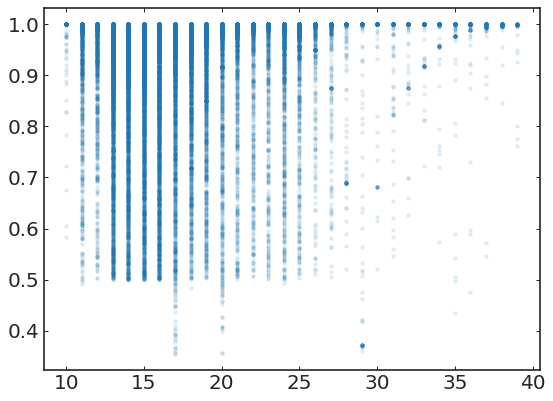

In [175]:
plt.plot(big.spt.values, pred_max_probs, '.', alpha=0.1)
#plt.plot(ucds.spt.values, max_probs, '.')

[Text(0, 0.5, 'Class'),
 Text(0.5, 0, 'Max Probability'),
 [Text(0, 0.0, 'Gal'),
  Text(0, 1.0, 'Early M'),
  Text(0, 2.0, 'M7-L0'),
  Text(0, 3.0, 'L'),
  Text(0, 4.0, 'T')]]

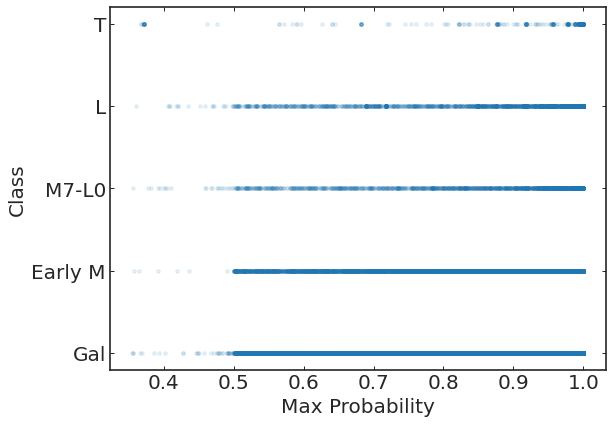

In [176]:
fig, ax=plt.subplots()
ax.scatter(pred_max_probs, pred_argma_probs, s=10., alpha=0.1, label='Selected')
#ax.scatter(max_probs, argma_probs, s=50., marker='+', label='Real')

ax.set(ylabel='Class', xlabel='Max Probability',
       yticks=[0., 1., 2., 3., 4.], yticklabels=['Gal', 'Early M', 'M7-L0', 'L', 'T'])


In [177]:
ucds[argma_probs==0.][['snr1', 'spt',  'spt_er', 'grism_id', 'distance']]

,snr1,spt,spt_er,grism_id,distance
164,7.224470,18.0,3.041381,goodss-06-g141_11322,1762.435593
172,86.875617,18.0,0.500000,par133-00012,397.910099
198,4.351430,21.0,4.031129,goodsn-15-g141_29162,2768.008613


In [178]:
ucds[argma_probs==1.][['snr1', 'spt', 'spt_er', 'grism_id', 'distance']]

,snr1,spt,spt_er,grism_id,distance
94,29.827710,17.0,1.118034,par434-00015,785.975485
93,23.163735,17.0,1.118034,par322-00030,744.652774
91,10.730531,17.0,1.118034,par473-00018,1091.894585
138,31.640446,17.0,1.118034,par260-00025,1022.168256
127,27.354046,17.0,1.118034,par332-00058,840.600721
108,22.803283,17.0,1.118034,par235-00024,578.622542
109,22.428460,17.0,1.118034,par50-00017,651.183596
118,26.662131,17.0,1.118034,par443-00009,821.168037
70,66.063315,17.0,1.118034,par356-00013,582.009531
26,28.282862,17.0,1.118034,par170-00053,949.742261


In [179]:
#

[Text(0.5, 0, 'Class'),
 Text(0, 0.5, 'Number'),
 [Text(0.0, 0, 'Gal'),
  Text(1.0, 0, 'Early M'),
  Text(2.0, 0, 'M7-L0'),
  Text(3.0, 0, 'L'),
  Text(4.0, 0, 'T')]]

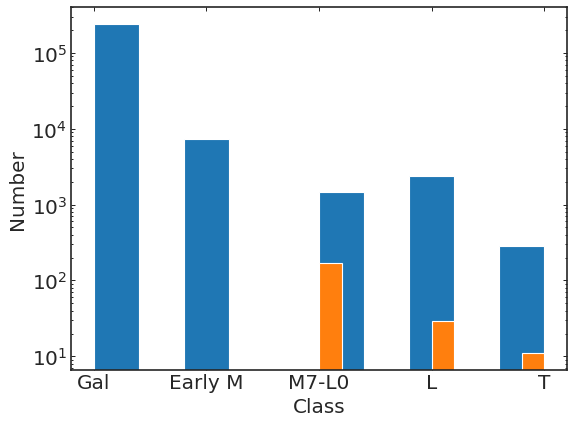

In [180]:
fig, ax=plt.subplots()
h=plt.hist(pred_argma_probs, log=True,   label='All predictions')
h=plt.hist(argma_probs[(argma_probs >=2. )], \
           label='SNR cut')

ax.set(xlabel='Class', ylabel='Number',
       xticks=[0., 1., 2., 3., 4.], xticklabels=['Gal', 'Early M', 'M7-L0', 'L', 'T'])


In [181]:
ucds.grism_id=ucds.grism_id.str.lower()
big.grism_id=big.grism_id.str.lower()

In [182]:

#add labels for index selection
ucds['selected_by_rf']=rf_ls['labels']
labelled['selected_by_nn']=ls['labels']

In [183]:
indices_to_use

[('CH_4/J-Cont H_2O-1+H_2O-2/J-Cont', 'M7-L0'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/H-Cont', 'L0-L5'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/H-Cont', 'L5-T0'),
 ('H_2O-1/J-Cont H_2O-2/J-Cont', 'T0-T5'),
 ('H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'Y dwarfs'),
 ('CH_4/H-Cont H_2O-1+CH_4/J-Cont', 'subdwarfs')]

In [184]:


#rfselection=pd.read_csv(wisps.OUTPUT_FILES+'/selected_by_rf.csv')
#nnres=pd.read_pickle(wisps.OUTPUT_FILES+'/deep_neural_net_classifier_results.pkl')

#rfselection.shape

#nnsel= pd.concat(nnres['selected'])

nnselection =pd.DataFrame()
rfselection=pd.DataFrame()

#nnselection['grism_id']=ucds.grism_id[ls['labels']]
#rfselection['grism_id']= ucds.grism_id[rf_ls['labels']]
#nnselection=nnselection.drop_duplicates('grism_id')



labelled=wisps.Annotator.group_by_spt(ucds, spt_label='spt', assign_number=False)

for idxk, k in indices_to_use:
    idx=slc_crts[idxk]
    labelled['selected_by_{}'.format(k)]= select_by_indices(labelled, idx, k)

labelled['index_label']=np.logical_or.reduce([labelled['selected_by_{}'.format(x)].values 
                                              for x in  np.vstack(indices_to_use)[:,1]])

for g in labelled.groupby('spt_range'):
    df0=g[1]
    print ('{}'.format(g[0]))
    print ('selected by rf {}'.format(len(df0[df0.selected_by_rf])))
    print ('selected by NN {}'.format(len(df0[df0.selected_by_nn])))
    print ('selected by indices {}'.format(len(df0[df0.index_label])))
    print ('selected by rf or indices {}'.format(len(df0[np.logical_or(df0.index_label,df0.selected_by_rf) ])))
    print ('selected by NOT rf and indices {}'.format(len(df0[np.logical_and(df0.index_label,~df0.selected_by_rf) ])))
    print ('selected by rf and NOT indices {}'.format(len(df0[np.logical_and(~df0.index_label,df0.selected_by_rf) ])))
    print ('selected by NN or indices {}'.format(len(df0[np.logical_or(df0.index_label,df0.selected_by_nn) ])))
    print ('selected by NOT NN and indices {}'.format(len(df0[np.logical_and(df0.index_label,~df0.selected_by_nn) ])))
    print ('selected by NN and NOT indices {}'.format(len(df0[np.logical_and(~df0.index_label,df0.selected_by_nn) ])))
    print ('---------------------------------------------------------------- ')

M7-L0
L0-L5
L5-T0
T0-T5
T5-T9
Y dwarfs
subdwarfs
L0-L5
selected by rf 14
selected by NN 19
selected by indices 20
selected by rf or indices 20
selected by NOT rf and indices 6
selected by rf and NOT indices 0
selected by NN or indices 21
selected by NOT NN and indices 2
selected by NN and NOT indices 1
---------------------------------------------------------------- 
L5-T0
selected by rf 7
selected by NN 8
selected by indices 9
selected by rf or indices 9
selected by NOT rf and indices 2
selected by rf and NOT indices 0
selected by NN or indices 9
selected by NOT NN and indices 1
selected by NN and NOT indices 0
---------------------------------------------------------------- 
M7-L0
selected by rf 163
selected by NN 162
selected by indices 184
selected by rf or indices 185
selected by NOT rf and indices 22
selected by rf and NOT indices 1
selected by NN or indices 188
selected by NOT NN and indices 26
selected by NN and NOT indices 4
----------------------------------------------------

In [185]:
ucds=labelled

In [186]:
def ucd_selection_method(ro):
    select=''
    if ro.index_label:
        select +="Indices, "
    if ro.selected_by_nn:
        select +="DNN, "
    if ro.selected_by_nn:
        select +="RF "
    if select.endswith(', '):
        select=select.replace(',', '')
    return select

In [187]:
#make that colormap
ucds['selection']=ucds.apply(ucd_selection_method, axis=1).values

In [188]:
bools=(ucds['selection']=='').values

In [189]:
labelled

,H_2O-1/J-Cont,H_2O-1/J-Cont_er,H_2O-2/H_2O-1,H_2O-2/H_2O-1_er,H-cont/H_2O-1,H-cont/H_2O-1_er,CH_4/H_2O-1,CH_4/H_2O-1_er,H_2O-2/J-Cont,H_2O-2/J-Cont_er,...,selected_by_L0-L5,selected_by_L5-T0,selected_by_T0-T5,selected_by_T5-T9,selected_by_Y dwarfs,selected_by_subdwarfs,index_label,selected_by_rf,selected_by_nn,selection
0,1.032943,0.199888,0.619468,0.137649,0.580530,0.126509,0.562893,0.120700,0.643796,0.122855,...,False,False,False,False,False,True,True,True,True,"Indices, DNN, RF"
102,0.899006,0.169717,0.628938,0.146108,0.557489,0.122671,0.676179,0.140152,0.574286,0.110517,...,False,False,False,False,False,False,True,False,True,"Indices, DNN, RF"
101,1.087996,0.081177,0.625200,0.051742,0.619980,0.048256,0.595645,0.048607,0.677325,0.050737,...,False,False,False,False,False,True,True,True,True,"Indices, DNN, RF"
100,1.122521,0.218450,0.591715,0.126441,0.581620,0.124499,0.577054,0.124003,0.645984,0.131842,...,False,False,False,False,False,True,True,True,True,"Indices, DNN, RF"
99,1.073933,0.004393,0.674631,0.003280,0.604862,0.003251,0.607215,0.003067,0.724804,0.003775,...,False,False,False,False,False,True,True,True,False,Indices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.335379,0.041910,0.374464,0.128552,1.540788,0.240759,0.711285,0.166620,0.128300,0.040093,...,False,False,True,False,False,False,True,True,True,"Indices, DNN, RF"
227,0.303713,0.078364,0.559621,0.332510,1.554362,0.594758,0.840608,0.370099,0.166462,0.074744,...,False,False,True,False,False,False,True,True,True,"Indices, DNN, RF"
228,0.147942,0.023794,0.414994,0.184712,3.276920,0.646437,0.868207,0.232711,0.061806,0.023654,...,False,False,True,True,True,False,True,True,True,"Indices, DNN, RF"
229,0.183316,0.090510,0.411472,5.192895,2.605460,10.146338,0.538239,6.545341,0.072326,0.058742,...,False,False,True,True,False,False,True,True,True,"Indices, DNN, RF"


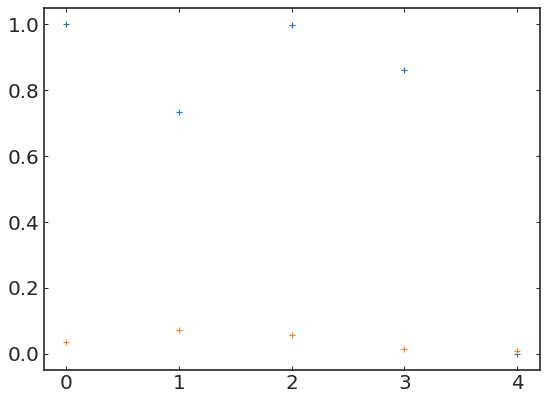

In [190]:
#h=plt.plot(ls['probs'][:,0], linestyle='--')
h=plt.plot(ls['probs'][bools][:,1], '+')
#h= plt.plot(rf_ls['probs'][:,0], linestyle='--')
h= plt.plot(rf_ls['probs'][bools][:,1], '+')

In [191]:
#plt.hist(np.array(ls['probs'])[:,0], log=True)

In [192]:
#probs=lp['probs']
#lab

In [193]:
#labels=np.logical_or.reduce((
#                                probs[:, 2] > .8, \
#                                 probs[:,3] >.95 ,\
#                                 probs[:,4] >0.8))
    
#labelsx=np.logical_and.reduce([ probs[:, 0] < .1, labels ])

In [194]:
#(labelsx==labels).all()

In [195]:
#plt.hist(np.array(probs[:, 0]), log=True)

In [196]:
#plt.plot(labels.astype(int), '.')
#plt.plot(labelsx.astype(int), '.')
#plt.plot(labels.astype(int), '.')

In [197]:
missed=ucds[ucds.grism_id.str.upper().isin(['PAR322-00030',  'PAR50-00017',  \
                                     'PAR170-00053', 'PAR293-00059',  \
                                     'PAR104-00019'])]

In [198]:
bs=idx.shapes

In [199]:
bx=[x for x in bs if x.shape_name=='M7-L0'][0]

In [200]:
ucds=wisps.tools.Annotator.group_by_spt(ucds, spt_label='spt')

In [201]:
len(ls['probs'][:,2][(ucds['spt_range']=='M7-L0').values])

193

In [202]:
#probability of being 
new_bools=(rf_ls['probs'][:,2]>0.1) & (rf_ls['probs'][:,3]>0.5)
missed_bools=(ucds.selection=='').values
#new_bools=(rf_ls['probs'][:,3]<0.5) & (rf_ls['probs'][:,3]>0.5)

In [203]:
ls['probs'][:,0][missed_bools]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([3.5884546e-04, 4.6500564e-03, 3.0517043e-04, 1.3468811e-01,
       1.0000000e+00], dtype=float32)>

In [204]:
rf_ls['probs'][:,0][missed_bools]

array([0.35812981, 0.18390326, 0.06613708, 0.75678335, 0.8868197 ])

In [205]:
ls['probs'][:,2][missed_bools]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.00064163, 0.2635042 , 0.00350542, 0.00670751, 0.        ],
      dtype=float32)>

In [206]:
ls['probs'][:,2][missed_bools]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.00064163, 0.2635042 , 0.00350542, 0.00670751, 0.        ],
      dtype=float32)>

In [207]:
#ucds[['spt', 'selection']][ np.array(ls['probs'][:,0]<0.5) & np.array(ls['probs'][:,1]>0.3)]

In [208]:
#

In [244]:
def plot_spectrum(s):
    s.plot(save=True, filename='/users/caganze/desktop/'+s.filename+'.pdf')
    

In [210]:
#rf_ls['labels']

In [211]:
#plt.plot(rf_ls['labels'], rf_ls['probs'][:,2], '.')

93     None
91     None
26     None
162    None
172    None
Name: spectra, dtype: object

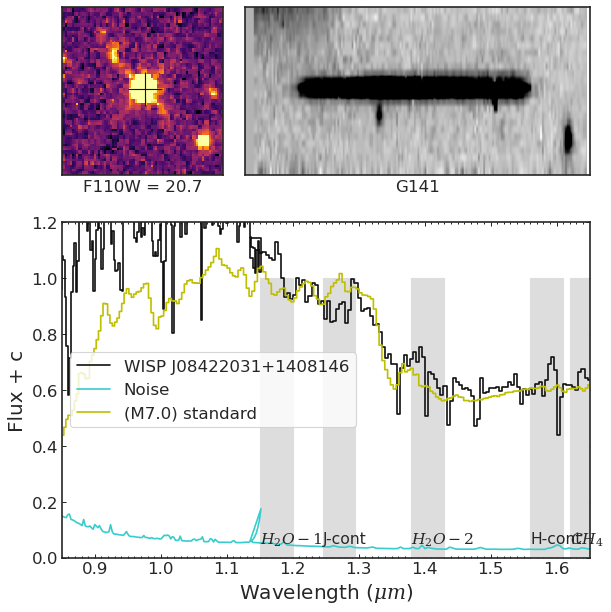

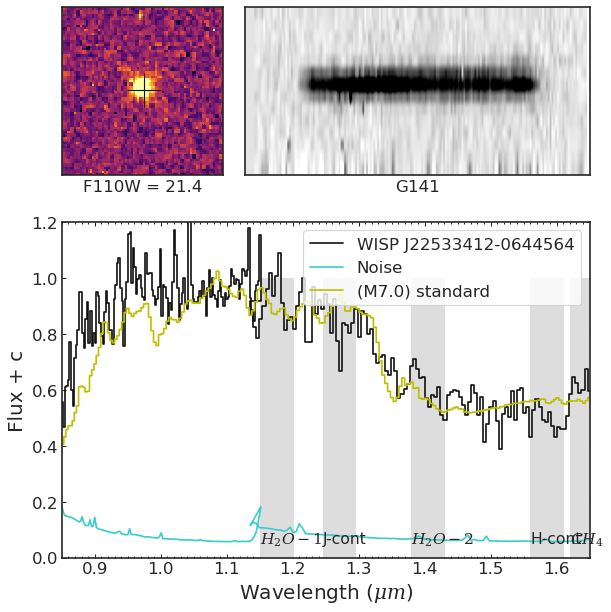

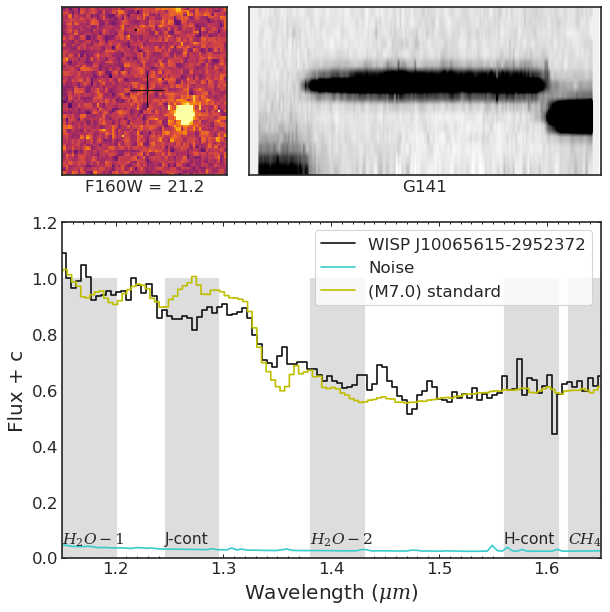

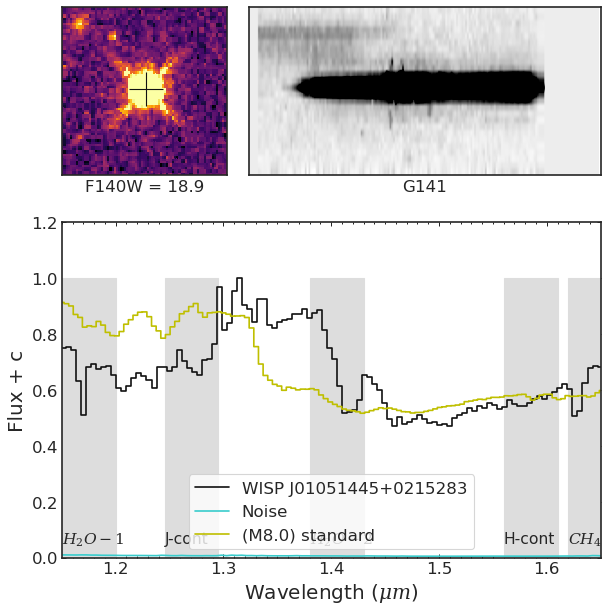

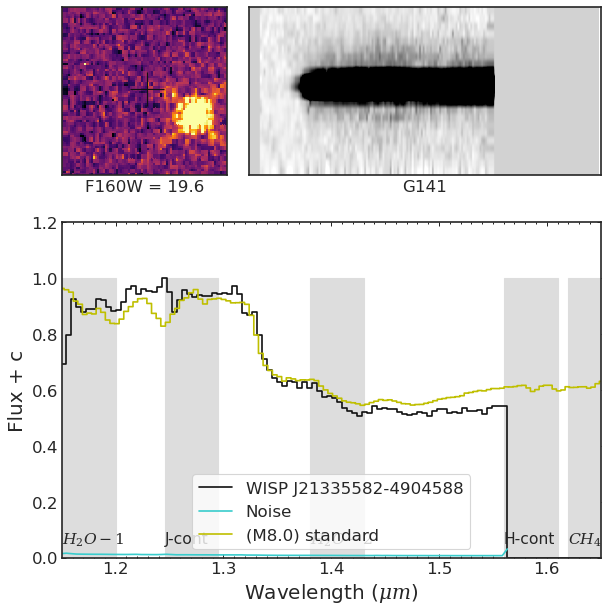

In [245]:
ucds[missed_bools].spectra.apply(plot_spectrum)

In [213]:
indices_to_use

[('CH_4/J-Cont H_2O-1+H_2O-2/J-Cont', 'M7-L0'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/H-Cont', 'L0-L5'),
 ('CH_4/H-Cont H_2O-1+H_2O-2/H-Cont', 'L5-T0'),
 ('H_2O-1/J-Cont H_2O-2/J-Cont', 'T0-T5'),
 ('H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'Y dwarfs'),
 ('CH_4/H-Cont H_2O-1+CH_4/J-Cont', 'subdwarfs')]

In [214]:
idx=slc_crts['CH_4/J-Cont H_2O-1+H_2O-2/J-Cont']
idx1=slc_crts['H_2O-1/J-Cont H_2O-2+CH_4/H-Cont']

In [215]:
bs=idx.shapes
bs1=idx1.shapes

In [216]:
bx=[x for x in bs if x.shape_name=='M7-L0'][0]
bx1=[x for x in bs1 if x.shape_name=='L0-L5'][0]

In [217]:
ucds[missed_bools].spt

93     17.0
91     17.0
26     17.0
162    18.0
172    18.0
Name: spt, dtype: float64

[Text(0.5, 1.0, 'L0-L5 Selection')]

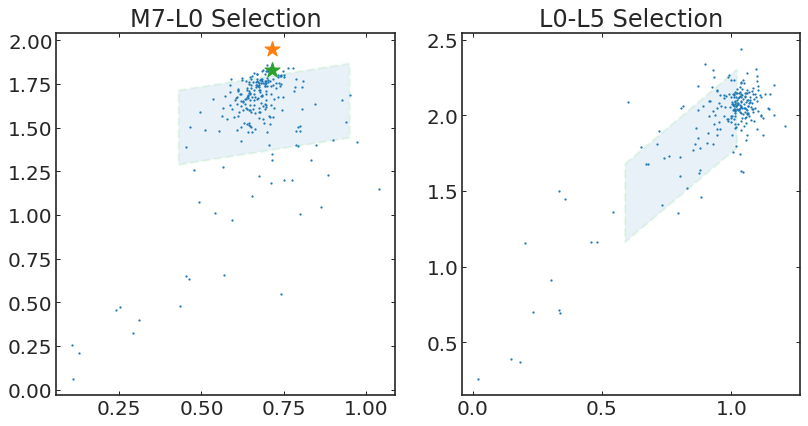

In [218]:
fig,(ax, ax1)=plt.subplots(ncols=2, figsize=(12, 6))
c=ax.scatter(ucds['CH_4/J-Cont'][~missed_bools], ucds['H_2O-1+H_2O-2/J-Cont'][~missed_bools], s=1)
c=ax.scatter(ucds['CH_4/J-Cont'][missed_bools].iloc[0], ucds['H_2O-1+H_2O-2/J-Cont'][missed_bools].iloc[0],
            marker='*', s=200)
c=ax.scatter(ucds['CH_4/J-Cont'][missed_bools].iloc[1], ucds['H_2O-1+H_2O-2/J-Cont'][missed_bools].iloc[1],
            marker='*', s=200)


c=ax1.scatter(ucds['H_2O-1/J-Cont'][~missed_bools], ucds['H_2O-2+CH_4/H-Cont'][~missed_bools], s=1)
c=ax1.scatter(ucds['H_2O-1/J-Cont'][missed_bools].iloc[-1], ucds['H_2O-2+CH_4/H-Cont'][missed_bools].iloc[-1],
               marker='*', s=200)

bx1.plot(ax=ax1)
bx.plot(ax=ax)


ax.set(title='M7-L0 Selection')
ax1.set(title='L0-L5 Selection')

In [219]:
#ucds[ucds['selection']=='']['f_test']

In [220]:
def formatted_distance(x):
    d= str(int(round(x.distance['val'].value, 0)))
    der=[str(int(abs(round(x.distance['er'].value[0], 0)))),\
            str(int(abs(round(x.distance['er'].value[0], 0))))]
         
    if abs(x.distance['er'].value[0])/x.distance['val'].value >0.9:
        return "$\\approx$"+d
    else:
        #return r'$'+d+'\substack{+'+der[0]+'\\\ -'+der[-1]+'}$'
        return d+'$^{+'+der[0]+'}'+'_{-'+der[1]+'}$'

In [235]:
fdf=ucds[~missed_bools]

In [236]:
latc_df=pd.DataFrame()
latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
latc_df['designation']=fdf.spectra.apply(lambda x: x.designation.upper())
latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper().replace('_', '-'))
latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
latc_df['spt']=fdf.spectra.apply(lambda x: splat.typeToNum(x.spectral_type[0]) +r'$\pm$'+ str(round(x.spectral_type[1], 1)))
latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
latc_df['f110']=fdf.spectra.apply(lambda x:  str(round(x.mags['F110W'][0],3)) +r'$\pm$'+ str(round(x.mags['F110W'][1],3)))
#latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
latc_df['f140']=fdf.spectra.apply(lambda x:  str(round(x.mags['F140W'][0],3)) +r'$\pm$'+  str(round(x.mags['F140W'][1],3)))
#latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
latc_df['f160']=fdf.spectra.apply(lambda x:   str(round(x.mags['F160W'][0],3)) + r'$\pm$'+ str(round(x.mags['F160W'][1],3)))
#latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
latc_df['distance']=fdf.spectra.apply(formatted_distance)
latc_df['Selected By']= fdf['selection']
latc_df=latc_df.replace('nan$\\pm$nan', '\nodata')

In [237]:
col_list=['designation','grism id', 'f110', 'f140', 'f160', \
          'snrj', 'spt', 'distance','Selected By']

In [238]:
latc_df[col_list].to_latex(wisps.LIBRARIES+'/candidates.tex',
             header=True, index=False, escape=False, na_rep=' ')

In [239]:
latc_df[col_list].to_latex('/users/caganze/desktop/candidates.tex',
             header=True, index=False, escape=False, na_rep=' ')

In [240]:
latc_df[['spt', 'grism id', 'snrj']][latc_df['Selected By']==''].values

array([], shape=(0, 3), dtype=object)

In [227]:
lp=select_by_neuralnet(big)

In [228]:
rf_lp=select_by_random_forest(big)

In [229]:
len(big[(big.snr1>=3) & lp['labels']])

1323

In [230]:
len(big[(big.snr1>=3) & rf_lp['labels']])

250

In [231]:
ucds[ucds.selection=='DNN, RF '][['spt', 'snr1']]

,spt,snr1
92,17.0,104.757937
112,17.0,9.739011
181,18.0,11.371843
142,18.0,7.103659
206,23.0,4.580164
223,31.0,4.696334


In [232]:
rf_ls['probs'][:,3][([ucds.selection==''])[0].values]

array([0.00515117, 0.00091539, 0.00150413, 0.02086953, 0.00273164])

In [233]:
ls['probs'][:,3][~ls['labels']]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([3.8223300e-04, 3.7079926e-06, 2.6907106e-08, 2.3457296e-06,
       9.4426817e-08, 6.8438807e-05, 9.9784947e-06, 3.2771738e-06,
       2.0076573e-06, 1.1128632e-06, 1.4056777e-06, 7.6109821e-08,
       6.3167136e-08, 3.0183926e-06, 3.1499271e-06, 1.0428610e-06,
       1.7135540e-05, 1.3306608e-08, 4.1156395e-06, 2.2907682e-06,
       5.8871674e-06, 2.5765472e-05, 3.0293247e-06, 5.7888478e-08,
       3.1392192e-06, 3.1134256e-05, 2.2718510e-07, 7.4399270e-07,
       1.3184915e-08, 1.2342266e-06, 0.0000000e+00, 1.8313313e-02,
       7.7705383e-01, 7.3178667e-01], dtype=float32)>

In [243]:
#plot and save new data
#ucds.to_pickle('~/research/wisps/libraries/real_ucds.pkl')

### 